In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [511]:
# If you need to download the data
import opendatasets as od
od.download('https://www.kaggle.com/datasets/CooperUnion/cardataset')

100%|██████████| 103k/103k [00:00<00:00, 5.54MB/s]

# Data Preparation

### Subfunctions for Data Formatting

Import csv data as a DataFrame

In [36]:
def get_data(file_path):
    df = pd.read_csv(file_path)
    return df

In [119]:
df.isnull().sum()
# Only ~70 items are missing variables of interest, so I think it's best to delete them.
def remove_nulls(df):
    df = df[df['engine_hp'].isnull() == False]
    df = df[df['engine_cylinders'].isnull() == False]
    df = df[df['number_of_doors'].isnull() == False]
    return df

Standardize Col Names and String values

In [63]:
def form_str_vals(df):
    df.columns = df.columns.str.lower().str.replace(' ', '_')
    str_features = df.dtypes.index[df.dtypes == object]
    for feature in str_features:
        df[feature] = df[feature].str.lower().str.replace(' ', '_')
    return df

Create Categorical Vars for # of Doors 
(default is 4 doors)

In [64]:
def add_doors(df):
    for num_doors in [2, 3]: # Defaulting to 4 doors, to avoid collinearity issues
        df[f'{num_doors}_doors'] = (df['number_of_doors'] == num_doors) * 2 # to convert from Bool to Int
    return df

Create log(msrp) variable (since msrp has a rightward tail)

In [65]:
def log_msrp(df):
    df['log_msrp'] = np.log1p(df['msrp'])
    return df

Create Categorical Vars for RWD, 4WD, and AWD (default is FWD)

In [67]:
def add_drive(df):
    for wheels in df['driven_wheels'].unique():
        df[wheels] = (df['driven_wheels'] == wheels) * 1 # Converting Bool to Int
    del df['front_wheel_drive'] # to avoid collinearity issues
    return df

Create Categorical Var for Manual (default is Automatic)

In [77]:
def add_trans(df):
    df['manual'] = (df['transmission_type'] == 'manual') * 1 # Convert Bool to Int
    return df

Create Age Variable

In [78]:
def add_age(df):
    df['age'] = 2017 - df['year']
    return df

Create Style Variable (Default is Coupe)

In [456]:
df['vehicle_style'].unique()
def add_style(df):
    for style in df['vehicle_style'].unique():
        df[style] = (df['vehicle_style'] == style) * 1
    del df['coupe']
    return df

Create Make Variable (Default is Fiat)

In [457]:
def add_make(df):
    for maker in df['make'].unique():
        df[maker] = (df['make'] == maker) * 1 # Convert Bool to Int
    del df['fiat'] # Fiat is default maker, to avoid collinearity issues
    return df
df['vehicle_style'].unique()

array(['coupe', 'convertible', 'sedan', 'wagon', '4dr_hatchback',
       '2dr_hatchback', '4dr_suv', 'passenger_minivan', 'cargo_minivan',
       'crew_cab_pickup', 'regular_cab_pickup', 'extended_cab_pickup',
       '2dr_suv', 'cargo_van', 'convertible_suv', 'passenger_van'],
      dtype=object)

### Main Function for Data Formatting

In [461]:
def get_formatted_data(file_name):
    df = get_data(file_name)
    df = form_str_vals(df)
    df = remove_nulls(df)
    df = add_doors(df)
    df = log_msrp(df)
    df = add_drive(df)
    df = add_age(df)
    df = add_trans(df)
    df = add_make(df)
    df = add_style(df)
    return df

In [462]:
df = get_formatted_data('chapt2/data.csv')
df.head()

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,...,4dr_suv,passenger_minivan,cargo_minivan,crew_cab_pickup,regular_cab_pickup,extended_cab_pickup,2dr_suv,cargo_van,convertible_suv,passenger_van
0,bmw,1_series_m,2011,premium_unleaded_(required),335.0,6.0,manual,rear_wheel_drive,2.0,"factory_tuner,luxury,high-performance",...,0,0,0,0,0,0,0,0,0,0
1,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",...,0,0,0,0,0,0,0,0,0,0
2,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,high-performance",...,0,0,0,0,0,0,0,0,0,0
3,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",...,0,0,0,0,0,0,0,0,0,0
4,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,luxury,...,0,0,0,0,0,0,0,0,0,0


### Preparation for Training and Evaluation

Partitioning Data into Train, Eval, and Test sets

In [ ]:
def partition(df):
    length = len(df)
    index = np.arange(length)
    rng = np.random.default_rng()
    rng.shuffle(index)
    shuffled_df = df.iloc[index]
    # Train is 60%, Eval is 20% and Test is 20% of the data
    train_df = shuffled_df.iloc[: 3 * (length // 5)]
    eval_df = shuffled_df.iloc[3 * (length // 5): 4 * (length // 5)]
    test_df = shuffled_df.iloc[4 * (length // 5):]
    return train_df, eval_df, test_df
    

# Model Specification

Selecting Feature Variables

In [458]:
# Leaving out Make, Style, Size, and Fuel.
features = ['engine_hp', 'engine_cylinders', 
           'highway_mpg', 'city_mpg', 'popularity', '2_doors', '3_doors',
           'rear_wheel_drive', 'all_wheel_drive', 'four_wheel_drive', 'age', 
           'manual']
# Adds Categoricals for Make
features_make = ['engine_hp', 'engine_cylinders', 
           'highway_mpg', 'city_mpg', 'popularity', '2_doors', '3_doors',
           'rear_wheel_drive', 'all_wheel_drive', 'four_wheel_drive', 'age', 
           'manual', 'bmw', 'audi', 'mercedes-benz', 'chrysler', 'nissan',
           'volvo', 'mazda', 'mitsubishi', 'ferrari', 'alfa_romeo', 'toyota',
           'mclaren', 'maybach', 'pontiac', 'porsche', 'saab', 'gmc',
           'hyundai', 'plymouth', 'honda', 'oldsmobile', 'suzuki', 'ford',
           'cadillac', 'kia', 'bentley', 'chevrolet', 'dodge', 'lamborghini',
           'lincoln', 'subaru', 'volkswagen', 'spyker', 'buick', 'acura',
           'rolls-royce', 'maserati', 'lexus', 'aston_martin', 'land_rover',
           'lotus', 'infiniti', 'scion', 'genesis', 'hummer', 'bugatti']
# Adds Categoricals for Style
features_style = ['engine_hp', 'engine_cylinders', 
           'highway_mpg', 'city_mpg', 'popularity', '2_doors', '3_doors',
           'rear_wheel_drive', 'all_wheel_drive', 'four_wheel_drive', 'age', 
           'manual','convertible', 'sedan', 'wagon', '4dr_hatchback',
           '2dr_hatchback', '4dr_suv', 'passenger_minivan', 'cargo_minivan',
           'crew_cab_pickup', 'regular_cab_pickup', 'extended_cab_pickup',
           '2dr_suv', 'cargo_van', 'convertible_suv', 'passenger_van']

Functions for Fitting and Evaluating Linear Regression Model

In [507]:
def fit(features, target, reg_constant=.001):
    features = features.copy()
    features['bias'] = np.ones(len(features))
    x = features.values
    features
    x_t = x.T
    x_t_x_inv = np.linalg.inv(x_t @ x + reg_constant * np.eye(x.shape[1]))
    y = target.values
    weights = x_t_x_inv @ x_t @ y
    return weights

In [437]:
def predictions(weights, features):
    features = features.copy()
    features['bias'] = np.ones(len(features))
    x = features.values
    return x @ weights

In [438]:
def RMSE(weights, features, target):
    y_hat = predictions(weights, features)
    y = target.values
    rmse = np.sqrt(((y - y_hat) ** 2)).mean()
    return rmse

In [439]:
def r_squared(weights, features, target):
    y_hat = predictions(weights, features)
    y = target.values
    TSS = ((y - y.mean()) ** 2).sum()
    RSS = ((y - y_hat) ** 2).sum()
    r_squared = 1 - RSS / TSS
    return r_squared

Testing Train, Eval, and Test Performance

In [470]:
def test_performance(df, features: list, target_variable, num_tests=100):
    train = 0
    train_r2 = 0
    evaluation = 0
    eval_r2 = 0
    test = 0
    test_r2 = 0
    for i in range(num_tests):
        train_df, eval_df, test_df = partition(df)
        weights = fit(train_df[features], train_df[target_variable])
        train += RMSE(weights, train_df[features], train_df[target_variable])
        evaluation += RMSE(weights, eval_df[features], eval_df[target_variable])
        test += RMSE(weights, test_df[features], test_df[target_variable])
        train_r2 += r_squared(weights, train_df[features], train_df[target_variable])
        eval_r2 += r_squared(weights, eval_df[features], eval_df[target_variable])
        test_r2 += r_squared(weights, test_df[features], test_df[target_variable])
    print('Test Results')
    print('~~~~~~~~~~~~')
    print(f'Training Data RMSE: {train/num_tests: .3f}')
    print(f'Eval Data RMSE:     {evaluation/num_tests: .3f}')
    print(f'Test Data RMSE:     {test/num_tests: .3f}')
    print(f'Training Data R^2:  {train_r2/num_tests: .3f}')
    print(f'Eval Data R^2:      {eval_r2/num_tests: .3f}')
    print(f'Test Data R^2:      {test_r2/num_tests: .3f}')
    print('~~~~~~~~~~~~')

In [471]:
test_performance(df,  features, 'log_msrp')
test_performance(df,  features_make, 'log_msrp')
test_performance(df,  features_style, 'log_msrp')

Test Results
~~~~~~~~~~~~
Training Data RMSE:  0.377
Eval Data RMSE:      0.379
Test Data RMSE:      0.378
Training Data R^2:   0.796
Eval Data R^2:       0.791
Test Data R^2:       0.790
~~~~~~~~~~~~
Test Results
~~~~~~~~~~~~
Training Data RMSE:  0.326
Eval Data RMSE:      0.330
Test Data RMSE:      0.329
Training Data R^2:   0.843
Eval Data R^2:       0.828
Test Data R^2:       0.828
~~~~~~~~~~~~
Test Results
~~~~~~~~~~~~
Training Data RMSE:  0.362
Eval Data RMSE:      0.365
Test Data RMSE:      0.364
Training Data R^2:   0.811
Eval Data R^2:       0.794
Test Data R^2:       0.788
~~~~~~~~~~~~


Histogram of Actual and Predicted log(MSRP)

<AxesSubplot: xlabel='log_msrp', ylabel='Count'>

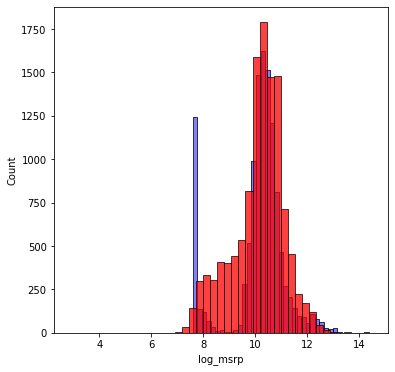

In [508]:
train_df, eval_df, test_df = partition(df)
weights = fit(train_df[features], train_df['log_msrp'])
preds = predictions(weights, df[features])

plt.figure(figsize=(6, 6))
sns.histplot(df['log_msrp'], bins=40, color='blue', alpha=.5)
sns.histplot(preds, bins=40, color='red')


In [509]:
for i in range(len(weights)):
    if i == len(weights) -1:
        print(f'Intercept : {weights[i]:.4f}')
    else:
        print(features[i] + f': {weights[i]:.4f}')

engine_hp: 0.0035
engine_cylinders: 0.0748
highway_mpg: -0.0240
city_mpg: 0.0192
popularity: -0.0000
2_doors: 0.0612
3_doors: -0.1000
rear_wheel_drive: -0.1009
all_wheel_drive: 0.0467
four_wheel_drive: -0.2429
age: -0.0960
manual: -0.1307
Intercept : 9.8471
